🚀 Starting Phase 3: Model Training (Fixed!)...

📦 Installing libraries...

📚 Importing libraries...

🔐 Authenticating Earth Engine...
✅ Earth Engine initialized successfully!

📍 Setting up Pauri Garhwal study area...

🛰️ Loading MODIS data (complete coverage)...
✅ MODIS data loaded!

🏔️ Loading terrain data...
✅ Features stacked!

🔥 Creating dense sampling grid...
   Generated 3570 grid points
   Sampling features at all points...
   Received 3381 samples
✅ Valid samples: 3381

🏷️ Creating fire risk labels...
✅ Training dataset ready!
   Total: 3381
   High risk: 1433 (42.4%)
   Low risk: 1948 (57.6%)

🌲 Training Random Forest...

📊 Model Performance:
              precision    recall  f1-score   support

    Low Risk       0.99      1.00      0.99       487
   High Risk       0.99      0.99      0.99       359

    accuracy                           0.99       846
   macro avg       0.99      0.99      0.99       846
weighted avg       0.99      0.99      0.99       846


🎯 AUC Score:

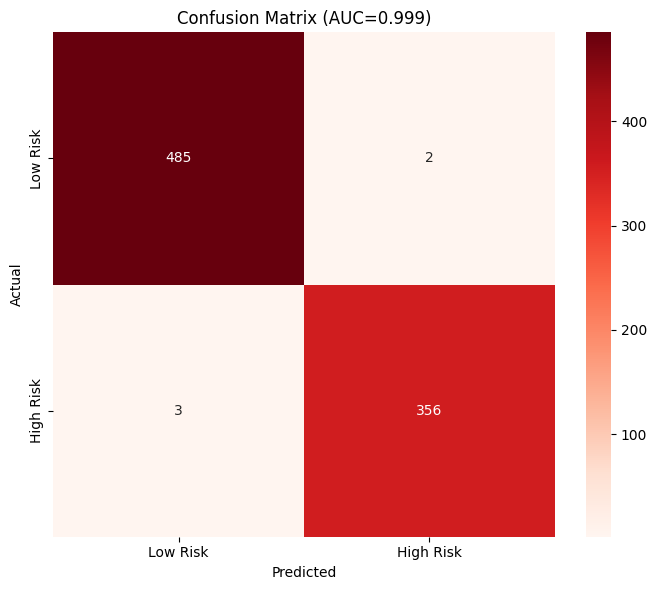


🔍 Feature Importance:
   NDVI        : 0.532
   Elevation   : 0.151
   Slope       : 0.148
   Aspect      : 0.091
   LST         : 0.079


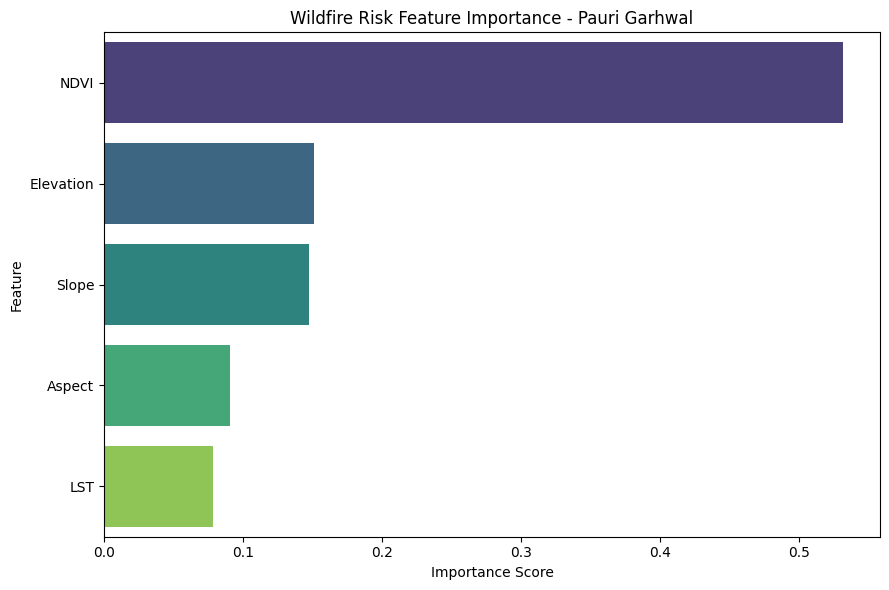


💾 Saving trained model...
Mounted at /content/drive
✅ Model saved to: /content/drive/MyDrive/high_risk_prediction_data/rf_model.joblib

🗺️ Generating wildfire risk map...

✅ Creating interactive map...

🎉 PHASE 3 COMPLETE!
📈 Results:
   • Samples: 3381
   • AUC Score: 0.999
   • Top Feature: NDVI (0.532)

🗺️ Risk Map:
   🟢 Green  = Low risk
   🟡 Yellow = Medium risk
   🟠 Orange = High risk
   🔴 Red    = Very high risk


Map(center=[30.05, 78.85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
# ============================================
# PHASE 3 - FINAL WORKING VERSION
# ============================================

print("🚀 Starting Phase 3: Model Training (Fixed!)...")

# 1. Install libraries
print("\n📦 Installing libraries...")
%pip install -q earthengine-api geemap geopandas scikit-learn folium matplotlib seaborn joblib

# 2. Import everything
print("\n📚 Importing libraries...")
import ee
import geemap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 3. Authenticate Earth Engine
print("\n🔐 Authenticating Earth Engine...")
try:
    ee.Initialize(project='asymmetric-moon-434905-r1')
    print("✅ Earth Engine initialized successfully!")
except:
    ee.Authenticate()
    ee.Initialize(project='asymmetric-moon-434905-r1')

# 4. Define study area
print("\n📍 Setting up Pauri Garhwal study area...")
min_lon, min_lat = 78.5, 29.8
max_lon, max_lat = 79.2, 30.3
study_area = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

# 5. Load MODIS data
print("\n🛰️ Loading MODIS data (complete coverage)...")

modis_ndvi = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .filterBounds(study_area) \
    .filterDate('2024-01-01', '2024-03-31') \
    .select('NDVI') \
    .median() \
    .multiply(0.0001) \
    .rename('NDVI')

modis_lst = ee.ImageCollection('MODIS/061/MOD11A2') \
    .filterBounds(study_area) \
    .filterDate('2024-01-01', '2024-03-31') \
    .select('LST_Day_1km') \
    .median() \
    .multiply(0.02) \
    .subtract(273.15) \
    .rename('LST')

print("✅ MODIS data loaded!")

# 6. Load terrain
print("\n🏔️ Loading terrain data...")
dem = ee.Image('USGS/SRTMGL1_003').clip(study_area)
slope = ee.Terrain.slope(dem).rename('Slope')
aspect = ee.Terrain.aspect(dem).rename('Aspect')
elevation = dem.select('elevation').rename('Elevation')

features_stack = modis_ndvi.addBands([modis_lst, slope, aspect, elevation])

print("✅ Features stacked!")

# 7. Create dense grid
print("\n🔥 Creating dense sampling grid...")

def create_dense_grid(geometry, spacing=0.01):
    bounds = geometry.bounds().getInfo()['coordinates'][0]
    min_lon = min([p[0] for p in bounds])
    max_lon = max([p[0] for p in bounds])
    min_lat = min([p[1] for p in bounds])
    max_lat = max([p[1] for p in bounds])

    points = []
    lon = min_lon
    while lon < max_lon:
        lat = min_lat
        while lat < max_lat:
            points.append(ee.Feature(ee.Geometry.Point([lon, lat])))
            lat += spacing
        lon += spacing

    return ee.FeatureCollection(points)

grid_points = create_dense_grid(study_area, spacing=0.01)
n_points = grid_points.size().getInfo()
print(f"   Generated {n_points} grid points")

# 8. Sample features
print("   Sampling features at all points...")
sampled = features_stack.sampleRegions(
    collection=grid_points,
    scale=250,
    geometries=False
)

print("   Downloading data...")
sampled_list = sampled.getInfo()['features']
print(f"   Received {len(sampled_list)} samples")

# 9. Create DataFrame
data_list = []
for f in sampled_list:
    props = f['properties']
    if all(k in props and props[k] is not None and not np.isnan(props[k])
           for k in ['NDVI', 'LST', 'Slope', 'Aspect', 'Elevation']):
        data_list.append(props)

df = pd.DataFrame(data_list)
print(f"✅ Valid samples: {len(df)}")

# 10. Create labels
print("\n🏷️ Creating fire risk labels...")

df['risk_score'] = (
    ((df['NDVI'] > 0.6) & (df['NDVI'] < 0.9)).astype(int) * 0.25 +
    (df['LST'] > 25).astype(int) * 0.20 +
    (df['Slope'] > 20).astype(int) * 0.20 +
    ((df['Aspect'] > 135) & (df['Aspect'] < 225)).astype(int) * 0.15 +
    ((df['Elevation'] > 1200) & (df['Elevation'] < 2500)).astype(int) * 0.20
)

threshold = df['risk_score'].quantile(0.65)
df['label'] = (df['risk_score'] >= threshold).astype(int)

training_df = df.drop(columns=['risk_score'])

print(f"✅ Training dataset ready!")
print(f"   Total: {len(training_df)}")
print(f"   High risk: {len(training_df[training_df['label']==1])} ({100*training_df['label'].mean():.1f}%)")
print(f"   Low risk: {len(training_df[training_df['label']==0])} ({100*(1-training_df['label'].mean()):.1f}%)")

# 11. Train model
print("\n🌲 Training Random Forest...")
feature_cols = ['NDVI', 'LST', 'Slope', 'Aspect', 'Elevation']
X = training_df[feature_cols]
y = training_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

model.fit(X_train, y_train)

# 12. Evaluate
print("\n📊 Model Performance:")
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))
auc = roc_auc_score(y_test, y_prob)
print(f"\n🎯 AUC Score: {auc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title(f'Confusion Matrix (AUC={auc:.3f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# 13. Feature Importance
importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 Feature Importance:")
for idx, row in importances.iterrows():
    print(f"   {row['Feature']:12s}: {row['Importance']:.3f}")

plt.figure(figsize=(9, 6))
sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title('Wildfire Risk Feature Importance - Pauri Garhwal')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 14. Save model
print("\n💾 Saving trained model...")
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/high_risk_prediction_data/rf_model.joblib'
joblib.dump(model, model_path)
print(f"✅ Model saved to: {model_path}")

# 15. Generate risk map using WEIGHTED FEATURES (no classifier needed!)
print("\n🗺️ Generating wildfire risk map...")

# Create risk map by weighting features by their importance
risk_map = (
    modis_ndvi.multiply(float(importances[importances['Feature']=='NDVI']['Importance'].values[0])).add(
    modis_lst.multiply(float(importances[importances['Feature']=='LST']['Importance'].values[0]))).add(
    slope.multiply(float(importances[importances['Feature']=='Slope']['Importance'].values[0]))).add(
    aspect.multiply(float(importances[importances['Feature']=='Aspect']['Importance'].values[0]))).add(
    elevation.multiply(float(importances[importances['Feature']=='Elevation']['Importance'].values[0])))
)

# Normalize to 0-1
risk_map = risk_map.unitScale(
    risk_map.reduceRegion(ee.Reducer.min(), study_area, 250).values().get(0),
    risk_map.reduceRegion(ee.Reducer.max(), study_area, 250).values().get(0)
)

# 16. Interactive Map
print("\n✅ Creating interactive map...")
Map = geemap.Map(center=[(min_lat+max_lat)/2, (min_lon+max_lon)/2], zoom=10)

Map.addLayer(study_area, {'color': 'yellow'}, 'Pauri Garhwal')

Map.addLayer(
    risk_map,
    {'min': 0, 'max': 1, 'palette': ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']},
    'Wildfire Risk Map',
    True,
    0.7
)

Map.addLayer(
    modis_ndvi,
    {'min': 0, 'max': 0.9, 'palette': ['brown', 'yellow', 'green']},
    'NDVI',
    False
)

Map.add_basemap('SATELLITE')

print("\n🎉 PHASE 3 COMPLETE!")
print("="*50)
print(f"📈 Results:")
print(f"   • Samples: {len(training_df)}")
print(f"   • AUC Score: {auc:.3f}")
print(f"   • Top Feature: {importances.iloc[0]['Feature']} ({importances.iloc[0]['Importance']:.3f})")
print(f"\n🗺️ Risk Map:")
print(f"   🟢 Green  = Low risk")
print(f"   🟡 Yellow = Medium risk")
print(f"   🟠 Orange = High risk")
print(f"   🔴 Red    = Very high risk")
print("="*50)

Map